# Goal
* Given an MLP, $f$ 
* Show how to calculate $$df/dx$$
* In constrast to calculating 
$$\frac{df_{loss}}{dx}$$
---
If our function is    
$$y = x^2$$    
Then,   

$$
\frac{dy}{dx} = 2x
$$

Then, $$\frac{d^2y}{dx^2} = 2$$

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [22]:
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, _input):
        return mish(_input)
    
def make_batch(x): return x[:,None]

def debatch(x, detach = True):
    x =  x.squeeze()
    if detach: x = x.detach()
    return x

def make_mlp(n = 20, layers_count = 3, act = Mish):
    layers = []
    layers.append(nn.Linear(1,n))
    layers.append(act())
    for i in range(layers_count -2):
        layers.append(nn.Linear(n,n))
        layers.append(act())
    layers.append(nn.Linear(n,1))
    mlp = nn.Sequential(*layers)
    return mlp

class Stepper:
    clear_grad = True
    def __call__(self,my_mlp,xb, yb, lr = 1e-1):
        yprime = my_mlp(xb)
        loss = F.mse_loss(yb,yprime )
        loss.backward()
        for name, param in my_mlp.named_parameters():
            param.data = param.data - param.grad*lr
        if self.clear_grad: my_mlp.zero_grad()
        self.yprime = yprime
        return yprime.squeeze().detach()

In [23]:
do_step = Stepper()

In [13]:
x = torch.linspace(-1,1, 30)

In [14]:
def my_func(x):
    y =  x**2
    dy = 2*x
    d2y = x*0+2
    return y, dy,d2y

In [15]:
y, dy, d2y = my_func(x)

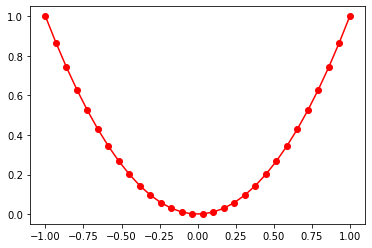

In [16]:
plt.plot(x,y, 'ro-')

In [19]:
mlp = make_mlp()

In [20]:
xb,yb = [make_batch(z) for z in [x,y]]


In [21]:
xb.requires_grad = True
yprime = mlp(xb)

In [29]:
for i in range(300):
    yprime_out = do_step(mlp,xb,yb,lr = 1e-1)

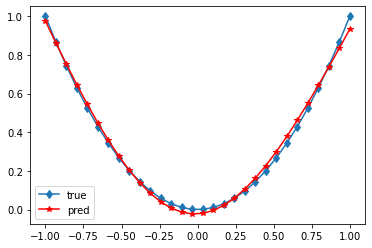

In [30]:
plt.plot(x,y, 'd-', label = 'true')
plt.plot(x, yprime_out, '*r-', label= 'pred')
plt.legend()

In [31]:
yprime = mlp(xb)
dydx = torch.autograd.grad(yprime.sum(), xb, create_graph=True )[0]
d2yd2x = torch.autograd.grad(dydx.sum(), xb, create_graph=True )[0]

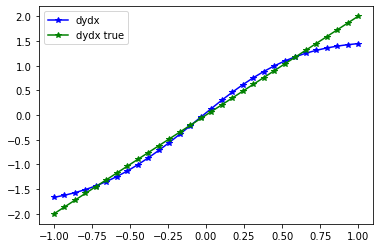

In [32]:
analytical_dydx = 2*x
plt.plot(x, debatch(dydx), '*b-', label= 'dydx')
plt.plot(x, dy, '*g-', label= 'dydx true')
plt.legend()

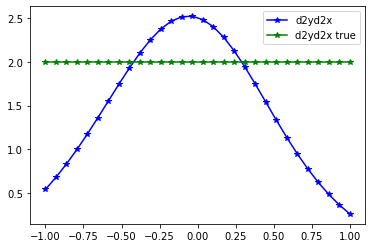

In [33]:
plt.plot(x, debatch(d2yd2x), '*b-', label= 'd2yd2x')
plt.plot(x, d2y, '*g-', label= 'd2yd2x true')
plt.legend()